# HR Analytics Data
>## Introduction

Dalam project ini saya akan menganalisa data dari database Human Resource. Dalam database ini terdapat 7 tabel yaitu :
- countries   : berisi nama negara di mana karyawan bekerja
- employees   : berisi data HR secara umum yaitu nama depan dan belakang, email, gaji, informasi kontak karyawan
- departments : berisi nama departemen dari perusahaan
- job history : riwayat kerja dari karyawan
- jobs        : berisi nama jabatan dan gaji tertinggi dan terendah dari jabatan tersebut
- locations   : berisi tempat dimana karyawan bekerja karena dilihat dari data perusahaan dapat diamsusikan sebagai perusahaan internasional
- regions     : wilayah tempat karyawan bekerja

Setiap Tabel dapat terhubung secara langsung maupun tidak langsung sehingga tabel dari database ini berkaitan

# Dabatase
>## Database Connecting

Berikut ini adalah tahap - tahapan untuk mengoneksikan sql ke dalam jupyter notebook. yang di lakukan pertama adalah melakukan import dari modul yang dibutuhkan lalu memulai koneksi dengan sql database ``human_resource``.

In [1]:
#sql connector
import mysql.connector as sqlcon

#data
import pandas as pd
import numpy as np

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
from plotly import version
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from IPython.display import Image

#uji hipotesis
from scipy.stats import shapiro
from scipy.stats import kruskal

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
mydb = sqlcon.connect(
    host = 'localhost',
    user = 'root',
    passwd = 'M4ut4hu4j4',
    database = 'human_resource'
)

Setelah itu mulai melakukan query dari database tersebut. Tabel yang digunakan adalah ```employees```, ```departments```, ```job_history```,```jobs```,```countries```,```regions```, dan ```locations```. Data yang dipilih dari masing -  masing tabel tersebut adalah :
- first name dan last name concat as name, data berisi nama depan dan belakang dari karyawan
- phone number, nomor telepon karyawan penting digunakan karena berisi data unique
- hire date, waktu karyawan dipekerjakan di perusahaan tersebut
- start date - end date, durasi karyawan bekerja
- salary, gaji karyawan
- min - max salary, gaji tertinggi dan terendah dari setiap departemen di perusahaan
- commission_pct, persentasi komisi yang diterima oleh karyawan
- department name, nama tempat departemen karyawan bekerja
- job_title, nama jabatan karyawan
- city, kota karyawan bekerja
- country id, code negara karyawan bekerja
- country name, nama negara karyawan bekerja
- region_name daerah karyawan bekerja

informasi di atas akan dibentuk dengan dataframe

In [5]:
mycursor = mydb.cursor()
query = '''SELECT  CONCAT(first_name,' ', LAST_NAME) AS name,e.phone_number,e.hire_date,j.start_date,j.end_date,e.salary,o.min_salary,o.max_salary,e.commission_pct,d.department_name,o.job_title,l.city,l.country_id,c.country_name,r.region_name
FROM employees e
left join departments d
ON e.department_id = d.department_id
left join job_history j
on e.employee_id = j.employee_id
left join jobs o
on j.job_id = o.job_id or e.job_id = o.job_id
left join locations l
on d.location_id = l.location_id
left join countries c
on l.country_id = c.country_id
left join regions r
on c.region_id = r.region_id'''
mycursor.execute(query)
result = mycursor.fetchall()
df = pd.DataFrame(result, columns = mycursor.column_names)
df.head()

,name,phone_number,hire_date,start_date,end_date,salary,min_salary,max_salary,commission_pct,department_name,job_title,city,country_id,country_name,region_name
0,Steven King,515.123.4567,1987-06-17,None,None,24000.00,20000,40000,0.00,Executive,President,Seattle,US,United States of America,Americas\r
1,Neena Kochhar,515.123.4568,1987-06-18,1989-09-21,1993-10-27,17000.00,15000,30000,0.00,Executive,Administration Vice President,Seattle,US,United States of America,Americas\r
2,Neena Kochhar,515.123.4568,1987-06-18,1989-09-21,1993-10-27,17000.00,4200,9000,0.00,Executive,Public Accountant,Seattle,US,United States of America,Americas\r
3,Neena Kochhar,515.123.4568,1987-06-18,1993-10-28,1997-03-15,17000.00,15000,30000,0.00,Executive,Administration Vice President,Seattle,US,United States of America,Americas\r
4,Neena Kochhar,515.123.4568,1987-06-18,1993-10-28,1997-03-15,17000.00,8200,16000,0.00,Executive,Accounting Manager,Seattle,US,United States of America,Americas\r


>## Database manipulation

### Missing Value

In [6]:
df.isna().sum()/df.shape[0]*100

name                0.000000
phone_number        0.000000
hire_date           0.000000
start_date         84.745763
end_date           84.745763
salary              0.000000
min_salary          0.000000
max_salary          0.000000
commission_pct      0.000000
department_name     0.847458
job_title           0.000000
city                0.847458
country_id          0.847458
country_name        0.847458
region_name         0.847458
dtype: float64

dapat dilihat bahwa banyak data kosong pada kolom ```start_date``` dan ```end_date``` melebihi 80 %. Pada awalnya diharapkan dari data tersebut data diketahui berapa lama karyawan bekerja di perusahaan namun karena data tersebut banyak yang kosong maka tidak terpakai padahal data tersebut sangat bagus untuk menunjukkan karir dari karyawan tersebut.

In [4]:
mycursor = mydb.cursor()
query = '''
SELECT  CONCAT(first_name,' ', LAST_NAME) AS name,e.phone_number,e.hire_date,e.salary,o.min_salary,o.max_salary,e.commission_pct,d.department_name,o.job_title,l.city,l.country_id,c.country_name,r.region_name
FROM employees e
left join departments d
ON e.department_id = d.department_id
left join jobs o
on e.job_id = o.job_id
left join locations l
on d.location_id = l.location_id
left join countries c
on l.country_id = c.country_id
left join regions r
on c.region_id = r.region_id'''
mycursor.execute(query)
result = mycursor.fetchall()
df = pd.DataFrame(result, columns = mycursor.column_names)
df.head()

,name,phone_number,hire_date,salary,min_salary,max_salary,commission_pct,department_name,job_title,city,country_id,country_name,region_name
0,Steven King,515.123.4567,1987-06-17,24000.00,20000,40000,0.00,Executive,President,Seattle,US,United States of America,Americas\r
1,Neena Kochhar,515.123.4568,1987-06-18,17000.00,15000,30000,0.00,Executive,Administration Vice President,Seattle,US,United States of America,Americas\r
2,Lex De Haan,515.123.4569,1987-06-19,17000.00,15000,30000,0.00,Executive,Administration Vice President,Seattle,US,United States of America,Americas\r
3,Alexander Hunold,590.423.4567,1987-06-20,9000.00,4000,10000,0.00,IT,Programmer,Southlake,US,United States of America,Americas\r
4,Bruce Ernst,590.423.4568,1987-06-21,6000.00,4000,10000,0.00,IT,Programmer,Southlake,US,United States of America,Americas\r


In [5]:
df.isna().sum()/df.shape[0]*100

name               0.000000
phone_number       0.000000
hire_date          0.000000
salary             0.000000
min_salary         0.000000
max_salary         0.000000
commission_pct     0.000000
department_name    0.934579
job_title          0.000000
city               0.934579
country_id         0.934579
country_name       0.934579
region_name        0.934579
dtype: float64

Masih Terdapat missing value dalam jumlah persentase yang sama, dapat dipastikan missing value berada dalam baris yang sama. Untuk itu dilakukan pengecekan.

In [6]:
df[df['department_name'].isna()]

,name,phone_number,hire_date,salary,min_salary,max_salary,commission_pct,department_name,job_title,city,country_id,country_name,region_name
78,Kimberely Grant,011.44.1644.429263,1987-09-03,7000.00,6000,12000,0.15,None,Sales Representative,None,None,None,None


In [7]:
df[77:79]

,name,phone_number,hire_date,salary,min_salary,max_salary,commission_pct,department_name,job_title,city,country_id,country_name,region_name
77,Jack Livingston,011.44.1644.429264,1987-09-02,8400.00,6000,12000,0.20,Sales,Sales Representative,OX9 9ZB,UK,United Kingdom,Europe\r
78,Kimberely Grant,011.44.1644.429263,1987-09-03,7000.00,6000,12000,0.15,None,Sales Representative,None,None,None,None


Bila dibandingkan dengan data sebelumnya data tersebut memiliki kesamaan nomor depan telepon sehingga dapat dipastikan mereka memiliki daerah kerja yang sama.

In [8]:
df.ffill(inplace=True)

In [9]:
df.isna().sum()

name               0
phone_number       0
hire_date          0
salary             0
min_salary         0
max_salary         0
commission_pct     0
department_name    0
job_title          0
city               0
country_id         0
country_name       0
region_name        0
dtype: int64

### Data Formatting

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             107 non-null    object
 1   phone_number     107 non-null    object
 2   hire_date        107 non-null    object
 3   salary           107 non-null    object
 4   min_salary       107 non-null    object
 5   max_salary       107 non-null    object
 6   commission_pct   107 non-null    object
 7   department_name  107 non-null    object
 8   job_title        107 non-null    object
 9   city             107 non-null    object
 10  country_id       107 non-null    object
 11  country_name     107 non-null    object
 12  region_name      107 non-null    object
dtypes: object(13)
memory usage: 11.0+ KB


Bila dilihat dari format data type yang ada,masih banyak data type yang salah. contohnya salary yang seharusnya integer atau float masih dalam bentuk object. Untuk itu perlu dilakukan data Formatting

In [11]:
df['hire_date'] = pd.to_datetime(df['hire_date'])
df['salary'] = df['salary'].astype('float')
df['min_salary'] = pd.to_numeric(df['min_salary'])
df['max_salary'] = pd.to_numeric(df['max_salary'])
df['commission_pct'] = df['commission_pct'].astype('float')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             107 non-null    object        
 1   phone_number     107 non-null    object        
 2   hire_date        107 non-null    datetime64[ns]
 3   salary           107 non-null    float64       
 4   min_salary       107 non-null    float64       
 5   max_salary       107 non-null    float64       
 6   commission_pct   107 non-null    float64       
 7   department_name  107 non-null    object        
 8   job_title        107 non-null    object        
 9   city             107 non-null    object        
 10  country_id       107 non-null    object        
 11  country_name     107 non-null    object        
 12  region_name      107 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(8)
memory usage: 11.0+ KB


### Data Duplicate

Untuk mengecek data duplikat, mudahnya adalah menggunakan unique value dari nomor telepon karena secara logika nomor telepon setiap orang berbeda.

In [13]:
df['phone_number'].value_counts()

011.44.1644.429265    1
650.123.2234          1
515.123.8181          1
603.123.6666          1
011.44.1644.429267    1
                     ..
515.123.4569          1
515.127.4561          1
650.124.1214          1
650.507.9833          1
650.127.1634          1
Name: phone_number, Length: 107, dtype: int64

Dapat dilihat jumlah data tetap sama 107 dengan data lainnya

### Data Outlier

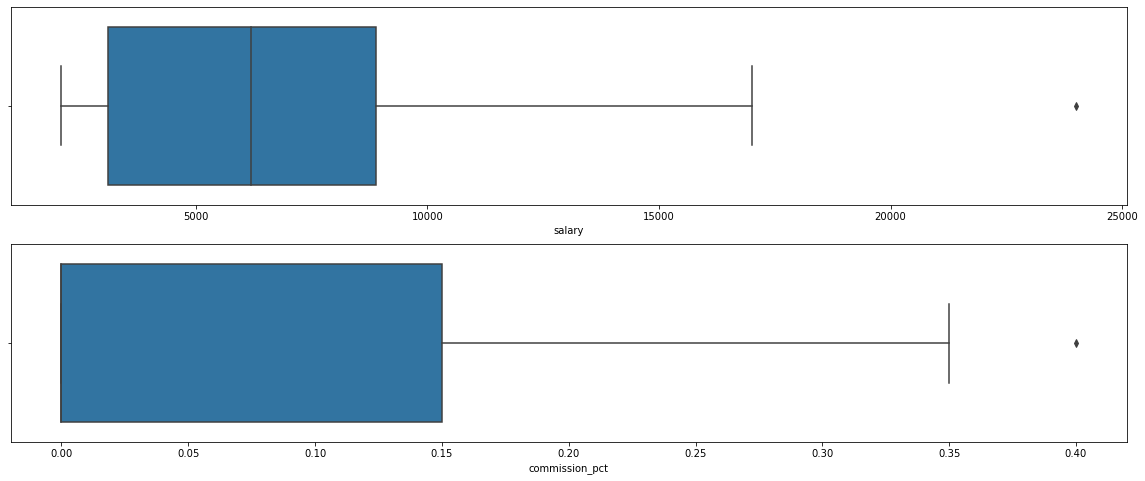

In [13]:
def outlier(col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    below = q1 - 1.5 * iqr
    above = q3 + 1.5 * iqr
    idx_outlier = df[(df[col] > above) | (df[col] < below)].index
    return idx_outlier

fig, axes= plt.subplots(2,1, figsize=(20,8))
for nf, ax in zip(['salary','commission_pct'], axes.flatten()):
    sns.boxplot(df[nf],orient='v', ax=ax)

In [26]:
outlier_salary = df.loc[outlier('salary')]
outlier_commission = df.loc[outlier('commission_pct')]
pd.concat([outlier_salary,outlier_commission])

,name,phone_number,hire_date,salary,min_salary,max_salary,commission_pct,department_name,job_title,city,country_id,country_name,region_name
0,Steven King,515.123.4567,1987-06-17,24000.0,20000.0,40000.0,0.0,Executive,President,Seattle,US,United States of America,Americas\r
45,John Russell,011.44.1344.429268,1987-08-01,14000.0,10000.0,20000.0,0.4,Sales,Sales Manager,OX9 9ZB,UK,United Kingdom,Europe\r


Terdapat dua outlier dari kolom ```salary``` dan ```commission_pct```, hal ini wajar dikarenakan kedua jabatan dari outlier tersebut memang tinggi. Gaji jabatan Eksekutif Presiden tertinggi dan Komisi dari Sales Manajer tertinggi.

>## Database Visualization

Data visualization akan menggunakan kombinasi dari Tableu dan modul yang ada dikarenakan lebih praktis dan mudah dilihat. Hal ini akan mempermudah dan mempercepat pekerjaan. Untuk itu data akan ada data diekspor kedalam excel lalu akan diproses di Tableu dan lainnya menggunakan modul yang lain.

In [19]:
df.to_excel("hr.xlsx")  

In [29]:
Image(url="piechart.png", width=1000, height=1323)

Bisa dilihat dari pie chart diatas departemen Sales menguasai pengeluaran terbanyak dalam urusan perusahaan menggaji karyawan dan juga hanya di departemen sales saja komisi berlaku sehingga wajar apabila perusahaan mengeluarkan uang lebih banyak untuk membayar gaji departemen ini. 

### Apakah perusahaan efektif dalam pengeluaran untuk menggaji Karyawan?

Seperti yang diketahui dalam grafik diatas perusahaan fokus terhadap departemen sales atau penjualan, sekarang akan dilakukan analisa lebih mendalam dalam departemen ini apakah pengeluaran departemen ini bisa lebih efektif karena dalam perusahaan perdagangan nyawa atau motor penggeraknya ada di departemen sales/penjualan.

In [46]:
Image(url="map_employee.png", width=650, height=860)

Bisa dilihat dipersebaran pekerja mayoritas berada di US sehingga dapat disimpulkan perusahaan ini berbasis di US.

In [47]:
Image(url="map_employee_sales.png", width=650, height=860)

Sedangkan untuk departemen Sales ternyata memiliki kantor di UK atau Inggris. Bisa dilihat pekerja Sales berada di Inggris. Hal ini tentu mempengaruhi pembayaran gaji karena perbedaan mata uang sehingga perusahaan membayar lebih mahal karena mata uang dollar dibawah pound Inggris. 

Mungkin ini terjadi karena komunikasi masih terbatas antar negara/benua, internet belum booming seperti sekarang sehingga perusahaan perlu membayar lebih untuk karyawan yang bekerja diluar US. Hal ini bisa diatasi dengan menggunakan perusahaan kedua atau subcontractor untuk menekan pengeluaran perusahaan karena selain Inggris pekerja di daerah lain seperti Kanada dan Jerman jumlahnya sedikit.

### Apakah gaji  dan bonus dari departemen sales saling berkorelasi?

Pertama kita uji distribusi terlebih dahulu dari data gaji

In [73]:
sw_statistic, sw_pvalue = shapiro(df['salary'])

if  sw_pvalue >0.05:
    print('normal distribution')
else:
    print('not normal distribution')

not normal distribution


In [51]:
df['salary'].corr(df['commission_pct'],method='spearman')

0.5828095386011345

<AxesSubplot:xlabel='salary', ylabel='commission_pct'>

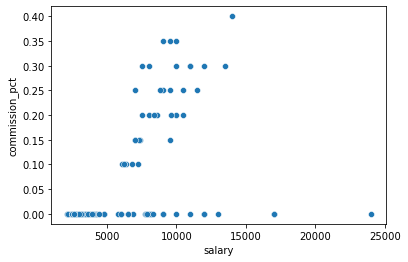

In [66]:
sns.scatterplot(data= df,x='salary', y = 'commission_pct')

Korelasinya tidak begitu kuat dan tidak terlalu lemah sehingga dapat disimpulkan korelasi data hubungannya sedang

### apakah gaji karyawan di setiap departemen dan jabatan berimbang?

In [67]:
Image(url="sales_commission.png", width=650, height=860)

Bisa dilihat di grafik diatas contohnya Lisa Ozer, walaupun berbeda jabatan gaji dan komisi dapat melampaui jabatan diatasnya Eleni Ziotkey meskipun berada di departemen yang sama. Hal ini menimbulkan pertanyaan baru, apakah gaji karyawan di setiap departemen dan jabatan berimbang? Hal ni penting dibahas karena disetiap jabatan perusahaan memiliki tanggungjawab yang berbeda sehingga terdapat gap dipendapatan. Tetapi gap tersebut tidak boleh terlalu jauh atau terlalu dekat karena dapat menimbulkan kecemburuan sosial dalam perusahaan sehingga menurunkan mental dan peforma dari karyawan. Berikut ini analisanya.

In [71]:
Image(url="salary.png", width=860, height=650)

In [81]:
for i in df['job_title'].unique():
    print('median salary {}: {}'.format(i,df[df['job_title']==i]['salary'].median()))
    
print('Total median salary',df['salary'].median())

median salary President: 24000.0
median salary Administration Vice President: 17000.0
median salary Programmer: 4800.0
median salary Finance Manager: 12000.0
median salary Accountant: 7800.0
median salary Purchasing Manager: 11000.0
median salary Purchasing Clerk: 2800.0
median salary Stock Manager: 7900.0
median salary Stock Clerk: 2700.0
median salary Sales Manager: 12000.0
median salary Sales Representative: 8200.0
median salary Shipping Clerk: 3100.0
median salary Administration Assistant: 4400.0
median salary Marketing Manager: 13000.0
median salary Marketing Representative: 6000.0
median salary Human Resources Representative: 6500.0
median salary Public Relations Representative: 10000.0
median salary Accounting Manager: 12000.0
median salary Public Accountant: 8300.0
Total median salary 6200.0


In [97]:
statistic,pvalue = kruskal(df[df['job_title']=='Sales Representative']['salary'],
       df[df['job_title']=='Marketing Representative']['salary'],
       df[df['job_title']=='Human Resources Representative']['salary'],
       df[df['job_title']=='Public Relations Representative']['salary'])

if  pvalue >0.05:
    print('Tidak ada perbedaan rata - rata gaji di jabatan representatif')
else:
    print('Setidaknya ada satu pasang kelompok yang rata - rata tidak sama di jabatan representatif')


Tidak ada perbedaan rata - rata gaji di jabatan representatif


In [92]:
for i in df['department_name'].unique():
    print('median salary {}: {}'.format(i,df[df['department_name']==i]['salary'].median()))
    
print('Total median salary',df['salary'].median())

median salary Executive: 17000.0
median salary IT: 4800.0
median salary Finance: 8000.0
median salary Purchasing: 2850.0
median salary Shipping: 3100.0
median salary Sales: 8900.0
median salary None: nan
median salary Administration: 4400.0
median salary Marketing: 9500.0
median salary Human Resources: 6500.0
median salary Public Relations: 10000.0
median salary Accounting: 10150.0
Total median salary 6200.0


In [98]:
statistic,pvalue = kruskal(df[df['department_name']=='Executive']['salary'],
       df[df['department_name']=='IT']['salary'],
       df[df['department_name']=='Finance']['salary'],
       df[df['department_name']=='Purchasing']['salary'],
       df[df['department_name']=='Shipping']['salary'],
       df[df['department_name']=='Sales']['salary'],   
       df[df['department_name']=='Administration']['salary'],
       df[df['department_name']=='Human Resources']['salary'],         
       df[df['department_name']=='Public Relations']['salary'],          
       df[df['department_name']=='Accounting']['salary'])

if  pvalue >0.05:
    print('Tidak ada perbedaan rata - rata gaji di antara departemen')
else:
    print('Setidaknya ada satu pasang kelompok yang rata - rata tidak sama di antara departemen')

Setidaknya ada satu pasang kelompok yang rata - rata tidak sama di antara departemen


Dari uji hipotesis diatas ternyata gaji antara setiap departemen tidak imbang atau ada gap, dapat terlihat gap gaji antara departemen eksekutif dan departemen shipping amat jauh. 

Uji hipotesis juga dilakukan terhadap jabatan yang sama, diambil sampel dari jabatan representatif dari setiap departemen. Hasil uji ternyata antara jabatan memiliki rata - rata gaji yang berimbang. Tidak ada perbedaan signifikan dengan jarak yang cenderung kecil di tingkatan jabatan representatif di setiap departemen dengan jarak terkecil 6k -10k dollar.

# Summary

Dengan data di atas dapat diambil kesimpulan bahwa perusahaan belum efektif dalam menggaji karyawannya. Hal ini bisa dibilang wajar karena data ini terbilang lama. Hal ini dapat diketahui dari tanggal perekrutan yaitu di tahun 1987 yang di mana informasi belum terbuka seperti saat ini.

Salah satu contohnya adalah perusahaan masih mengandalkan representatif di luar markas perusahaan di USA. Mereka masih menggaji sales atau penjual dari luar negeri yang apabila pada saat sekarang dengan internet sosial media dengan affiliatornya yang biasanya menjadi garda terdepan dalam penjualan. Tetapi pada saat itu juga bisa diatasi dengan menggunakan subcontractor untuk mengontrak sales untuk meningkatkan penjualan. Sehingga perusahaan tidak perlu menggaji secara besar kepada tenaga sales tetapi lebih menekankan pada pemberian komisi untuk setiap produk yang berhasil dijual.

Yang berikutnya adalah gaji tidak berimbang antar departemen. Hal ini dapat dibuktikan dengan grafik dan uji hipotesis yang telah dilakukan.  Walaupun di tingakatan jabatan yang sama gaji berimbang, bila dilihat dalam grafik dapat diasumsikan terdapat gap gaji yang besar ditingkat manajer dan representatif yang membuat gap gaji antar departemen menjadi tidak berimbang. Hal ini perlu ditindaklanjuti karena terdapat gap yang besar di tingkatan jabatan berbeda seperti contohnya di departemen marketing.